# NPFL097 Assignment 1 - Latent Dirichlet Allocation
## Andrew McIsaac

In [2]:
#!/usr/bin/env python3

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
import random
import pickle 
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

# Load documents

newsgroups_train = fetch_20newsgroups(subset='train')
print(len(newsgroups_train.data), " documents loaded.")

print("Example document:")
print(newsgroups_train.data[0])


# Preprocess documents - lemmatization and stemming

def lemmatize_stemming(text):
    stemmer = SnowballStemmer("english")
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

processed_docs = list(map(preprocess, newsgroups_train.data))

print("Example document - lemmatized and stemmed:")
print(processed_docs[0])


# Construct dictionary

dictionary = gensim.corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

print("Dictionary size: ", len(dictionary))

# Filter words in documents

docs = list()
maxdoclen = 0 
for doc in processed_docs:
    docs.append(list(filter(lambda x: x != -1, dictionary.doc2idx(doc))))
    maxdoclen = max(maxdoclen, len(docs[-1]))

print("Example document - filtered:")
print(docs[0])

print("Maximum document length:", maxdoclen)

doc_cnt = len(docs)
wrd_cnt = len(dictionary)

11314  documents loaded.
Example document:
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----





Example document - lemmatized and stemmed:
['lerxst', 'thing', 'subject', 'nntp', 'post', 'host', 'organ', 'univers', 'maryland', 'colleg', 'park', 'line', 'wonder', 'enlighten', 'door', 'sport', 'look', 'late', 'earli', 'call', 'brick

#### 1. Implement the Latent Dirichlet allocation topic model, as described in the previous lectures. Set the hyperparameters $\alpha = 0.1$, $\gamma = 0.1$ and set number of topics $K = 20$. (4 pts)

In [3]:
def _init_lda(docs, doc_cnt, wrd_cnt, topics):
    # initialise z matrix
    z = [[0 for _ in range(len(d))] for d in docs]
    
    cd = np.zeros((doc_cnt, topics))
    cw = np.zeros((wrd_cnt, topics))
    c = np.zeros((topics))
    
    # initialise z_{nd} randomly for d in num_docs, for n in num words in doc d
    # compute initial counts cd, cw, c
    for d, doc in enumerate(docs):
        for n, word in enumerate(doc):
            z[d][n] = random.randint(0, topics-1)
            k = z[d][n]
            cd[d, k] += 1
            cw[word, k] += 1
            c[k] += 1
    return z, cd, cw, c

In [4]:
def lda(docs, topics, doc_cnt, wrd_cnt, iterations=50, alpha=0.1, gamma=0.1):
    
    
    prob = np.zeros((topics))

    z, cd, cw, c = _init_lda(docs, doc_cnt, wrd_cnt, topics)
    
    # quasi-dictionaries for saving values after every iteration
    cd_dict = np.zeros((iterations+1, doc_cnt, topics))
    cw_dict = np.zeros((iterations+1, wrd_cnt, topics))
    c_dict = np.zeros((iterations+1, topics))
    cd_dict[0], cw_dict[0], c_dict[0] = cd, cw, c
    for i in trange(iterations):
        for d, doc in enumerate(docs):
            for n, word in enumerate(doc):
                k_t = z[d][n]
                cd[d, k_t] -= 1
                cw[word, k_t] -= 1
                c[k_t] -= 1
                #calculate updated probabilities
                for k in range(topics):
                    prob[k] = ((alpha + cd[d, k]) / ((topics * alpha) + len(docs[d])-1)) \
                            * ((gamma + cw[word, k]) / ((wrd_cnt * gamma) + c[k]))
                # normalise to get proper probability distribution
                prob = prob/np.sum(prob)
                # sample topic k from probability distribution prob
                k = np.random.choice(topics, p=prob)
                # increment counters
                z[d][n] = k
                cd[d, k] += 1
                cw[word, k] += 1
                c[k] += 1
        cd_dict[i+1] = cd
        cw_dict[i+1] = cw
        c_dict[i+1] = c
    return cd_dict, cw_dict, c_dict

In [122]:
# set the hyperparameters
iterations=50
alpha=0.1
gamma=0.1
topics=20

In [123]:
# run algorithm
cd_dict, cw_dict, c_dict = lda(docs, topics, doc_cnt, wrd_cnt, iterations, alpha, gamma)

100%|██████████| 50/50 [1:18:01<00:00, 93.64s/it]


In [ ]:
# store/load saved values
with open("cd_dict.pkl", "wb") as f:
    pickle.dump(cd_dict, f)
with open("cw_dict.pkl", "wb") as f:
    pickle.dump(cw_dict, f)
with open("c_dict.pkl", "wb") as f:
    pickle.dump(c_dict, f)

In [5]:
with open("cd_dict.pkl", "rb") as f:
    cd_dict = pickle.load(f)
with open("cw_dict.pkl", "rb") as f:
    cw_dict = pickle.load(f)
with open("c_dict.pkl", "rb") as f:
    c_dict = pickle.load(f)

#### 2. Plot the distribution over topics for one chosen document after initialization and after 1st, 2nd, 5th, 10th, 20th, and 50th iteration. Comment on these. (1 pt)

In [124]:
# restore beta, theta from saved counts for all iterations
beta = np.zeros((iterations+1, wrd_cnt, topics))
theta = np.zeros((iterations+1, doc_cnt, topics))

for i in range(iterations+1):
    for m in range(wrd_cnt):
        beta[i,m] = (gamma + cw_dict[i,m]) / (wrd_cnt*gamma + cw_dict[i,m].sum())
    
    for d in range(doc_cnt):
        theta[i,d] = (alpha + cd_dict[i,d]) / (topics*alpha + cd_dict[i,d].sum())

In [125]:
def plot_doc_topic_distributions(doc, theta):
    X = [i for i in range(1, topics+1)]
    
    fig, ax = plt.subplots(3, 3, sharey=True, figsize=(8,8))
    fig.tight_layout(h_pad=2)
    ax[0, 0].bar(X, theta[0,doc])
    ax[0, 0].title.set_text('After Initialisation')
    ax[0, 1].bar(X, theta[1,doc])
    ax[0, 1].title.set_text('Iteration 1')
    ax[0, 2].bar(X, theta[2,doc])
    ax[0, 2].title.set_text('Iteration 2')
    ax[1, 0].bar(X, theta[5,doc])
    ax[1, 0].title.set_text('Iteration 5')
    ax[1, 1].bar(X, theta[10,doc])
    ax[1, 1].title.set_text('Iteration 10')
    ax[2, 0].bar(X, theta[20,doc])
    ax[2, 0].title.set_text('Iteration 20')
    ax[2, 1].bar(X, theta[50,doc])
    ax[2, 1].title.set_text('Iteration 50')
    
    plt.setp(ax[-1, :], xlabel='Topic k')
    plt.setp(ax[:, 0], ylabel='p')
    plt.tight_layout()

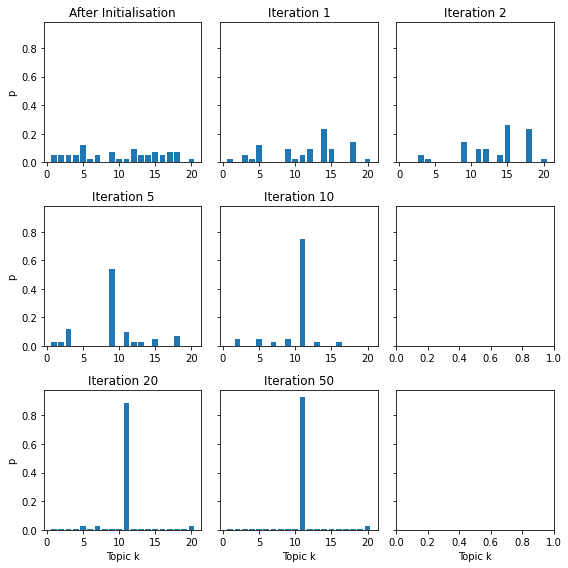

In [126]:
plot_doc_topic_distributions(99, theta)

The distribution over topics shows clearly how, with a concentration parameter of 0.1, a reasonably uniform initial distribution, with every topic having a probability between 0 and 0.1, steadily determines just a few topics that are assigned high probability. The rest of the topics then have near zero probabilities. These high probabilities tend to continue to grow over iterations, concentrating the probability density into just a few topics.

For example, after iteration 1, a few topics have increased their probability density, while for around half the probability has already gone to near zero. By iteration 10 this is further exemplified, with topic 16 having a probability around 0.6 and just a few other topics having any visible probability.

By the final iteration the same topic has by far the largest probability (around 0.7), while most of the rest of the probability mass is distributed across just three or four topics.

#### 3. Compute the word entropy for each of the topics as a function of the number of Gibbs iterations. (1 pt)

In [5]:
def entropy(cw_dict, docs, topics, iterations, gamma):
    H = np.zeros((iterations+1, topics))
    N_train = sum(len(docs[i]) for i in range(len(docs)))
    # sum_m=1^M c_w[m][k]
    cw_topic_array = np.sum(cw_dict, axis=1)
    
    for k in range(topics):
        for i in range(iterations+1):
            entropy = 0
            for w in range(wrd_cnt):
                pwk = (gamma + cw_dict[i, w, k]) \
                    / ((wrd_cnt * gamma) + cw_topic_array[i, k])
                logpwk = np.log2(pwk)
                entropy += pwk * logpwk
            H[i,k] = -entropy
    return H

In [128]:
H = entropy(cw_dict, docs, topics, iterations, gamma)

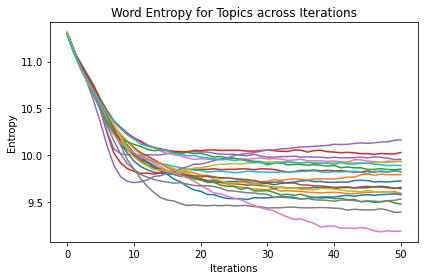

In [129]:
plt.plot(H)
plt.title('Word Entropy for Topics across Iterations')
plt.xlabel('Iterations')
plt.ylabel('Entropy')
plt.tight_layout()

#### 4. Show histograms of the most frequent 20 words of three chosen topics after 50 Gibbs iterations. (1 pt)

Histograms of the 5th, 11th, and 20th topics are shown

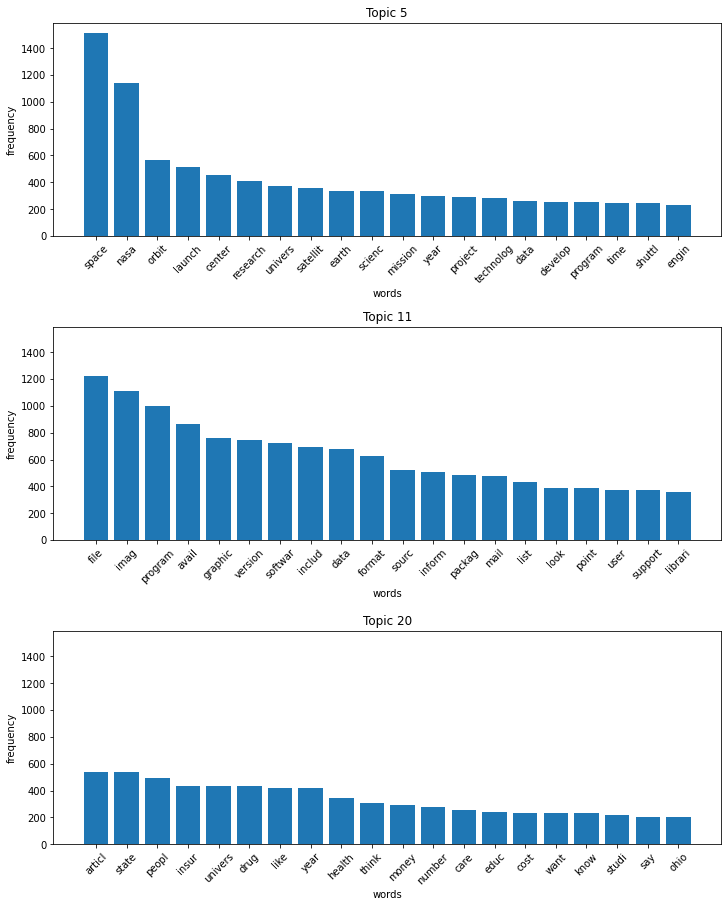

In [130]:
ks = [4, 10, 19]
#dictionary.get(np.argmax(cw[:, k]))

fig, ax = plt.subplots(3, 1, sharey=True, figsize=(10,12))
fig.tight_layout(h_pad=7)


for i, k in enumerate(ks):
    inds = np.argpartition(cw_dict[-1, :, k], -20)[-20:]
    sorted_inds = inds[np.argsort(cw_dict[-1, :, k][inds])][::-1]
    words = [dictionary.get(i) for i in sorted_inds]
    totals = cw_dict[-1, :, k][sorted_inds]
    
    ax[i].bar(range(len(words)), totals, align='center')
    ax[i].title.set_text('Topic %s' % (k+1))
    plt.sca(ax[i])
    plt.xticks(range(len(words)), words, rotation=45)
    plt.setp(ax[i], xlabel='words', ylabel='frequency')


#### 5. Preprocess the test data in the same way as the training data. For filtration, use the dictionary from the training data. 

In [6]:

# Load documents

newsgroups_test = fetch_20newsgroups(subset='test')
print(len(newsgroups_test.data), " documents loaded.")

print("Example document:")
print(newsgroups_test.data[0])


# Preprocess documents - lemmatization and stemming

def lemmatize_stemming(text):
    stemmer = SnowballStemmer("english")
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

processed_docs_test = list(map(preprocess, newsgroups_test.data))

print("Example document - lemmatized and stemmed:")
print(processed_docs_test[0])


# Construct dictionary - use dictionary from training data

dictionary = gensim.corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

print("Dictionary size: ", len(dictionary))

# Filter words in documents

docs_test = list()
maxdoclen_test = 0 
for doc in processed_docs_test:
    docs_test.append(list(filter(lambda x: x != -1, dictionary.doc2idx(doc))))
    maxdoclen_test = max(maxdoclen_test, len(docs_test[-1]))

print("Example document - filtered:")
print(docs_test[0])

print("Maximum document length:", maxdoclen_test)


# Set the hyperparameters

iterations = 50 
topics = 20 
alpha = 0.1 
gamma = 0.1

doc_cnt_test = len(docs_test)
wrd_cnt_test = len(dictionary)

7532  documents loaded.
Example document:
From: v064mb9k@ubvmsd.cc.buffalo.edu (NEIL B. GANDLER)
Subject: Need info on 88-89 Bonneville
Organization: University at Buffalo
Lines: 10
News-Software: VAX/VMS VNEWS 1.41
Nntp-Posting-Host: ubvmsd.cc.buffalo.edu


 I am a little confused on all of the models of the 88-89 bonnevilles.
I have heard of the LE SE LSE SSE SSEI. Could someone tell me the
differences are far as features or performance. I am also curious to
know what the book value is for prefereably the 89 model. And how much
less than book value can you usually get them for. In other words how
much are they in demand this time of year. I have heard that the mid-spring
early summer is the best time to buy.

			Neil Gandler

Example document - lemmatized and stemmed:
['ubvmsd', 'buffalo', 'neil', 'gandler', 'subject', 'need', 'info', 'bonnevill', 'organ', 'univers', 'buffalo', 'line', 'news', 'softwar', 'vnew', 'nntp', 'post', 'host', 'ubvmsd', 'buffalo', 'littl', 'confus', 'model',

#### Compute the per-word perplexity of the test data for the state after 50 Gibbs iterations. 

In [7]:
def _init_lda_test(docs, doc_cnt, topics):
    # initialise z matrix
    z = [[0 for _ in range(len(d))] for d in docs]
    
    cd = np.zeros((doc_cnt, topics))
    
    # initialise z_{nd} randomly for d in num_docs, for n in num words in doc d
    # compute initial counts cd, cw, c
    for d, doc in enumerate(docs):
        for n, word in enumerate(doc):
            z[d][n] = random.randint(0, topics-1)
            k = z[d][n]
            cd[d, k] += 1
    return z, cd

In [8]:
def lda_test(cw_dict, c_dict, docs, topics, doc_cnt, wrd_cnt, iterations, alpha, gamma):
    
    prob = np.zeros((topics))
    
    cw = cw_dict[-1]
    c = c_dict[-1]

    z, cd = _init_lda_test(docs, doc_cnt, topics)
    
    # dictionaries for saving values after every iteration
    cd_dict = np.zeros((iterations+1, doc_cnt, topics))
    cd_dict[0] = cd
    for i in trange(iterations):
        for d, doc in enumerate(docs):
            for n, word in enumerate(doc):
                k_t = z[d][n]
                cd[d, k_t] -= 1
                #calculate updated probabilities
                for k in range(topics):
                    prob[k] = ((alpha + cd[d, k]) / ((topics*alpha) + len(docs[d])-1)) \
                            * ((gamma + cw[word, k]) / ((wrd_cnt * gamma) + c[k]))
                # normalise to get proper probability distribution
                prob = prob/np.sum(prob)
                # sample topic k from probability distribution prob
                k = np.random.choice(topics, p=prob)
                z[d][n] = k
                cd[d, k] += 1
        cd_dict[i+1] = cd
    return cd_dict

In [134]:
cd_dict_test = lda_test(cw_dict, c_dict, docs_test, topics, doc_cnt_test, wrd_cnt_test, iterations, alpha, gamma)

100%|██████████| 50/50 [45:03<00:00, 54.08s/it]


In [ ]:
with open("cd_dict_test.pkl", "wb") as f:
    pickle.dump(cd_dict_test, f)

In [67]:
with open("cd_dict_test.pkl", "rb") as f:
    cd_dict_test = pickle.load(f)

In [9]:
def entropy_test(cw_dict, cd_dict, docs, topics, wrd_cnt, alpha, gamma):
    H = 0
    N = sum(len(docs[i]) for i in range(len(docs)))
    # sum_{m=1}^{M} c_w[m][k]
    cw_topic_array = np.sum(cw_dict, axis=1)
    
    log_p_w = 0
    for d, doc in enumerate(docs):
        for n, word in enumerate(doc):
            pwd = 0
            for k in range(topics):
                first_part = (gamma + cw_dict[-1, word, k]) \
                            / ((wrd_cnt) * gamma + cw_topic_array[-1, k])
                second_part = (alpha + cd_dict[-1, d, k]) \
                            / ((topics * alpha) + len(docs[d]))
                pwd += first_part * second_part
            log_p_w += np.log2(pwd)
    H = (-1/N) * log_p_w
    return H

In [136]:
topics=20
alpha=0.1
gamma=0.1
H = entropy_test(cw_dict, cd_dict_test, docs_test, topics, wrd_cnt_test, alpha, gamma)
PP = 2**H

In [137]:
PP

1488.7123121003108

In [138]:
H

10.539849270276774

#### Per-word perplexity of the test data for the state after 50 Gibbs iterations is $\text{PP} = 1476.95$

#### Compare it to a simple bayesian model not using any hidden variables and using only one distribution over words $\beta$ for all documents with symmetric Dirichlet prior with and concentration parameter $γ = 0.1$. (2 pts)

In [139]:
# compute counts from training data
cw_simple = np.zeros((wrd_cnt))
for d, doc in enumerate(docs):
    for n, word in enumerate(doc):
        cw_simple[word] += 1

In [140]:
def bayesian_entropy_test(cw, docs, wrd_cnt, iterations, gamma):
    H = 0
    # N_test is the total number of words in the test data
    N = sum(len(docs[i]) for i in range(len(docs)))
    # sum_m=1^M c_w[m][k]
    cw_sum = np.sum(cw)
    
    log_p_w = 0
    for d, doc in enumerate(docs):
        for n, word in enumerate(doc):
            pwd = (gamma + cw[word]) / ((wrd_cnt * gamma) + cw_sum)
            log_p_w += np.log2(pwd)
    H = (-1/N) * log_p_w
    return H

In [141]:
H_simple = bayesian_entropy_test(cw_simple, docs_test, wrd_cnt, iterations, gamma)
PP_simple = 2**H_simple

In [142]:
PP_simple

2627.0348276547647

The perplexity of the test data for the LDA algorithm is much lower than the simple bayesian model (1477 vs 2627), with the LDA perplexity 43% lower than the simple model.

#### 6. Try to change the number of topics $K$, the hyperparameters $\alpha$ and $\beta$ and the number of Gibbs iterations. How the performance changes? (1 pt)

In [10]:
def tune_lda(iterations, alpha, gamma, topics):
    cd_tune, cw_tune, c_tune = lda(docs, topics, doc_cnt, wrd_cnt, iterations, alpha, gamma)
    cd_tune_test = lda_test(
        cw_tune, c_tune, docs_test, topics, doc_cnt_test, wrd_cnt_test, iterations, alpha, gamma)
    
    return cw_tune, cd_tune, c_tune, cd_tune_test

In [144]:
# decrease topics to 10
iterations=50
alpha=0.1
gamma=0.1
topics=10
cw_tune1, cd_tune1, c_tune1, cd_tune_test_1 = \
    tune_lda(iterations, alpha, gamma, topics)

100%|██████████| 50/50 [36:13<00:00, 43.46s/it]


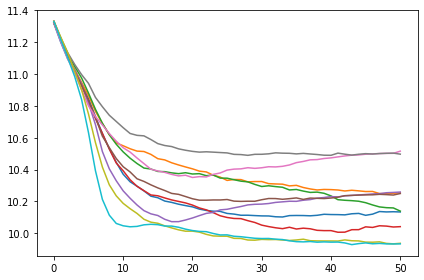

In [147]:
iterations=50
alpha=0.1
gamma=0.1
topics=10
H_tune1 = entropy(cw_tune1, docs, topics, iterations, gamma)
plt.plot(H_tune1)
plt.tight_layout()

In [148]:
iterations=50
alpha=0.1
gamma=0.1
topics=10
H_tune1_test = entropy_test(cw_tune1, cd_tune_test_1, docs_test, topics, wrd_cnt_test, alpha, gamma)
PP_tune1 = 2**H_tune1_test
PP_tune1

1665.6375248133288

Perplexity for 50 iters, $\alpha = 0.1$, $\gamma = 0.1$, 10 topics is 1665

In [149]:
# increase topics to 50
iterations=50
alpha=0.1
gamma=0.1
topics=50
cw_tune2, cd_tune2, c_tune2, cd_tune_test_2 = \
    tune_lda(iterations, alpha, gamma, topics)

100%|██████████| 50/50 [16:45:09<00:00, 1206.20s/it]    


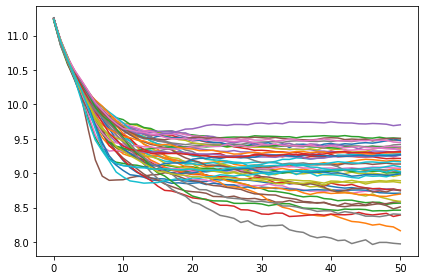

In [150]:
iterations=50
alpha=0.1
gamma=0.1
topics=50
H_tune2 = entropy(cw_tune2, docs, topics, iterations, gamma)
plt.plot(H_tune2)
plt.tight_layout()

In [151]:
iterations=50
alpha=0.1
gamma=0.1
topics=50
H_tune2_test = entropy_test(cw_tune2, cd_tune_test_2, docs_test, topics, wrd_cnt_test, alpha, gamma)

PP_tune2 = 2**H_tune2_test
PP_tune2

1265.0520242656446

Perplexity for 20 iters, $\alpha = 0.1$, $\gamma = 0.1$, 50 topics is 1265

In [51]:
# set alpha to 1
iterations=20
alpha=1
gamma=0.1
topics=20
cw_tune3, cd_tune3, c_tune3, cd_tune_test_3 = \
    tune_lda(iterations, alpha, gamma, topics)

100%|██████████| 20/20 [18:49<00:00, 56.46s/it]


In [ ]:
H_tune3 = entropy(cd_tune3, docs, topics, iterations, gamma)
plt.plot(H_tune3)
plt.tight_layout()

![tune_3](tune_3.png)

In [ ]:
H_tune3_test = entropy_test(cd_tune3, cd_tune_test_3, docs_test, topics, wrd_cnt_test, alpha, gamma)

PP_tune3 = 2**H_tune3_test
PP_tune3

Perplexity for 20 iters, $\alpha = 1$, $\gamma = 0.1$, 20 topics is 1600

In [ ]:
# set gamma to 1
iterations=20
alpha=0.1
gamma=1
topics=20
cw_tune4, cd_tune4, c_tune4, cd_tune_test_4 = \
    tune_lda(iterations, alpha, gamma, topics)

In [ ]:
iterations=20
alpha=0.1
gamma=1
topics=20
H_tune4 = entropy(cd_tune4, docs, topics, iterations, gamma)
plt.plot(H_tune4)
plt.tight_layout()

In [56]:
iterations=20
alpha=0.1
gamma=1
topics=20
H_tune4_test = entropy_test(cw_tune4, cd_tune_test_4, docs_test, topics, wrd_cnt_test, alpha, gamma)

PP_tune4 = 2**H_tune4_test
PP_tune4

11601.400597609943

Perplexity for 20 iters, $\alpha = 0.1$, $\gamma = 1$, 20 topics is 11601

In [58]:
# set gamma to 1, alpha to 0.01
iterations=20
alpha=0.01
gamma=1
topics=20
cw_tune5, cd_tune5, c_tune5, cd_tune_test_5 = \
    tune_lda(iterations, alpha, gamma, topics)

100%|██████████| 20/20 [21:24<00:00, 64.22s/it]


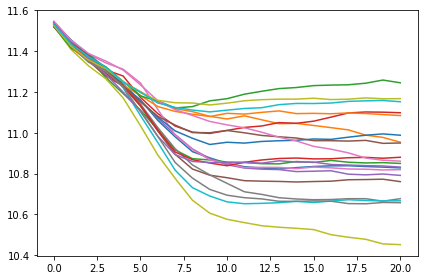

In [95]:
iterations=20
alpha=0.01
gamma=1
topics=20
H_tune5 = entropy(cd_tune5, docs, topics, iterations, gamma)
plt.plot(H_tune5)
plt.tight_layout()

In [96]:
iterations=20
alpha=0.01
gamma=1
topics=20
H_tune5_test = entropy_test(cd_tune5, cd_tune_test_5, docs_test, topics, wrd_cnt_test, alpha, gamma)

PP_tune5 = 2**H_tune5_test
PP_tune5

2873.29191277243

Perplexity for 20 iters, $\alpha = 0.01$, $\gamma = 1$, 20 topics is 2873

In [62]:
# set gamma to 1, alpha to 0.1
iterations=50
alpha=0.1
gamma=1
topics=40
cw_tune6, cd_tune6, c_tune6, cd_tune_test_6 = \
    tune_lda(iterations, alpha, gamma, topics)

100%|██████████| 50/50 [1:46:25<00:00, 127.71s/it]  


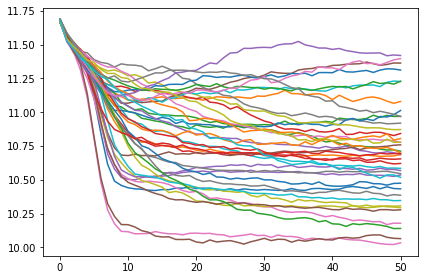

In [109]:
iterations=50
alpha=0.1
gamma=1
topics=40
H_tune6 = entropy(cd_tune6, docs, topics, iterations, gamma)
plt.plot(H_tune6)
plt.tight_layout()

In [111]:
iterations=50
alpha=0.1
gamma=1
topics=40
H_tune6_test = entropy_test(cd_tune6, cd_tune_test_6, docs_test, topics, wrd_cnt_test, alpha, gamma)

PP_tune6 = 2**H_tune6_test
PP_tune6

3787.8899274064584

Perplexity for 50 iters, $\alpha = 0.1$, $\gamma = 1$, 40 topics is 3787

In [114]:
# set gamma to 1, alpha to 0.1
iterations=100
alpha=0.1
gamma=0.1
topics=20
cw_tune6, cd_tune6, c_tune6, cd_tune_test_6 = \
    tune_lda(iterations, alpha, gamma, topics)

100%|██████████| 100/100 [1:27:22<00:00, 52.42s/it]


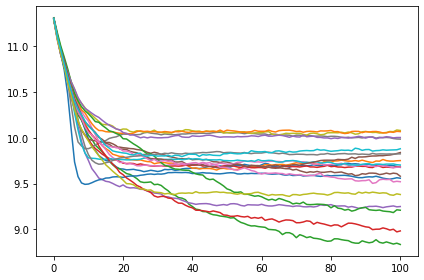

In [115]:
H_tune6 = entropy(cd_tune6, docs, topics, iterations, gamma)
plt.plot(H_tune6)
plt.tight_layout()

In [118]:
H_tune6_test = entropy_test(cd_tune6, cd_tune_test_6, docs_test, topics, wrd_cnt_test, alpha, gamma)

PP_tune6 = 2**H_tune6_test
PP_tune6

3549.603341605321

Perplexity for 50 iters, $\alpha = 0.1$, $\gamma = 1$, 40 topics is 3787